<a href="https://colab.research.google.com/github/aaanthonyyy/CircuitNet/blob/master/notebooks/meta_learning_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Few-Shot learning with Reptile

**Author:** [ADMoreau](https://github.com/ADMoreau)<br>
**Date created:** 2020/05/21<br>
**Last modified:** 2020/05/30<br>
**Description:** Few-shot classification of the Omniglot dataset using Reptile.

## Introduction

The [Reptile](https://arxiv.org/abs/1803.02999) algorithm was developed by OpenAI to
perform model agnostic meta-learning. Specifically, this algorithm was designed to
quickly learn to perform new tasks with minimal training (few-shot learning).
The algorithm works by performing Stochastic Gradient Descent using the
difference between weights trained on a mini-batch of never before seen data and the
model weights prior to training over a fixed number of meta-iterations.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import pathlib


## Define the Hyperparameters


In [139]:
learning_rate = 0.001
meta_step_size = 0.25

inner_batch_size = 30
eval_batch_size = 30

# meta_iters = 1000
meta_iters = 5000
eval_iters = 5
inner_iters = 5

eval_interval = 1
train_shots = 20
shots = 5
classes = 6

DATA_PATH = pathlib.Path("/content/drive/MyDrive/3020_drive/Data/Devset_orientation")


## Prepare the data

The [Omniglot dataset](https://github.com/brendenlake/omniglot/) is a dataset of 1,623
characters taken from 50 different alphabets, with 20 examples for each character.
The 20 samples for each character were drawn online via Amazon's Mechanical Turk. For the
few-shot learning task, `k` samples (or "shots") are drawn randomly from `n` randomly-chosen
classes. These `n` numerical values are used to create a new set of temporary labels to use
to test the model's ability to learn a new task given few examples. In other words, if you
are training on 5 classes, your new class labels will be either 0, 1, 2, 3, or 4.
Omniglot is a great dataset for this task since there are many different classes to draw
from, with a reasonable number of samples for each class.


In [140]:

class Dataset:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
        split = "training" if training else "validation"
        # ds = tfds.load("omniglot", split=split, as_supervised=True, shuffle_files=False)

        ds = keras.utils.image_dataset_from_directory(
            DATA_PATH,
            # subset=split,
            image_size=(128,128),
            color_mode='grayscale',
            seed=123,
            batch_size=None,
            shuffle=True
        )

        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.
        self.data = {}

        def extraction(image, label):
            # This function will shrink the Omniglot images to the desired size,
            # scale pixel values and convert the RGB image to grayscale
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.resize(image, [128, 128])/255.0
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 128, 128, 1))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 128, 128, 1))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
        
        if split:
            return dataset, test_images, test_labels
        return dataset


import urllib3

urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.
train_dataset = Dataset(training=True)
test_dataset = Dataset(training=False)


Found 590 files belonging to 6 classes.
Found 590 files belonging to 6 classes.


## Visualize some examples from the dataset


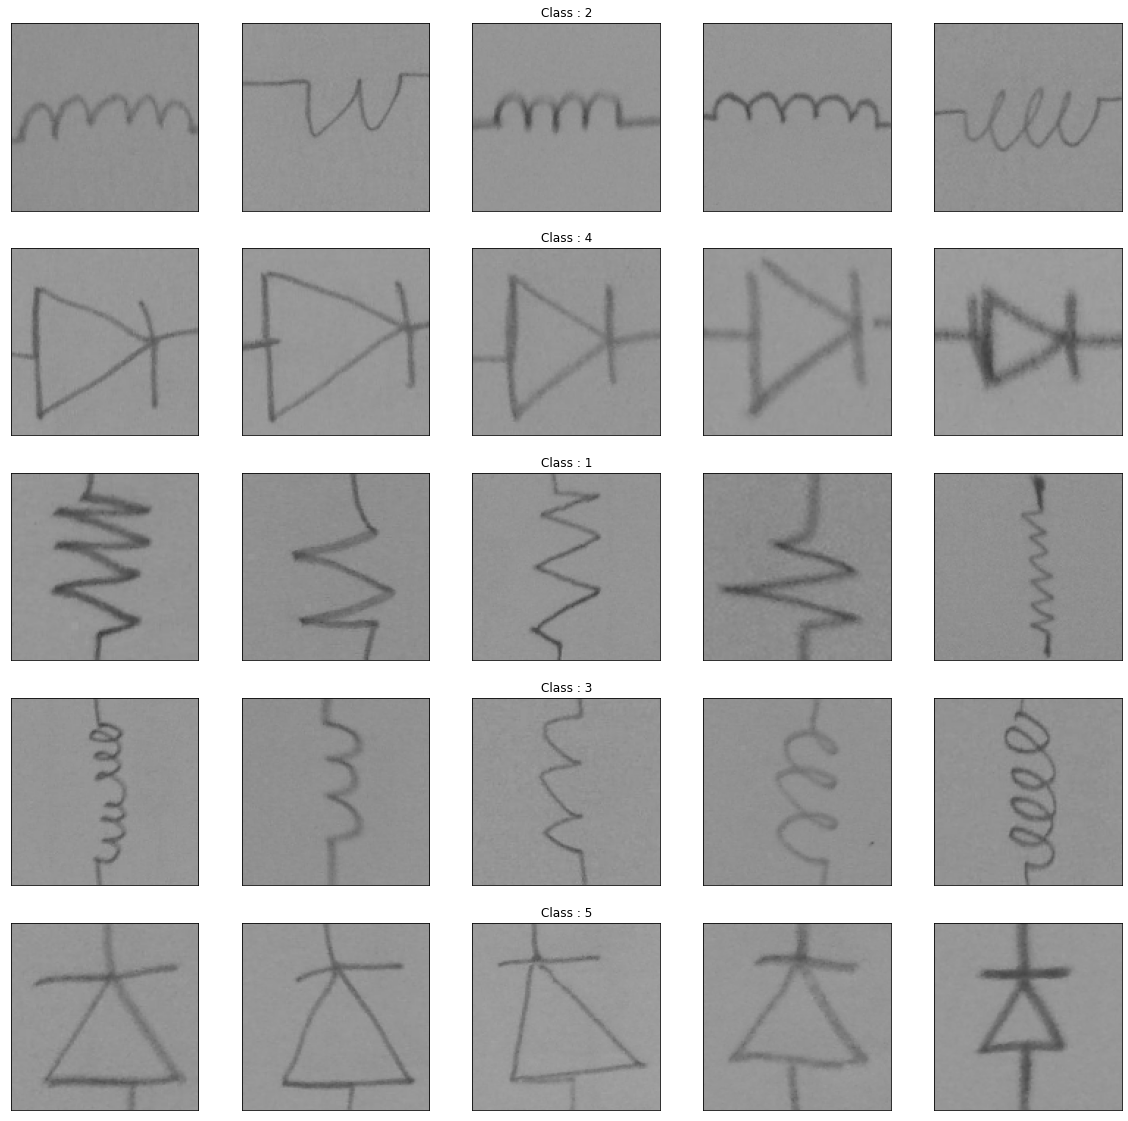

In [141]:
_, axarr = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for a in range(5):
    for b in range(5):
        temp_image = train_dataset.data[sample_keys[a]][b]
        temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
        temp_image *= 255
        temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        if b == 2:
            axarr[a, b].set_title("Class : " + sample_keys[a])
        axarr[a, b].imshow(temp_image, cmap="gray")
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)
plt.show()


## Build the model


In [143]:

# def conv_bn(x):
#     x = layers.Conv2D(filters=64, kernel_size=3)(x)
#     x = layers.MaxPooling2D()(x)
#     return layers.ReLU()(x)

inputs = layers.Input(shape=(128, 128, 1))

x = layers.Conv2D(32, 4, activation='relu')(inputs)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, 4, activation='relu', kernel_regularizer="l2")(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, 5, activation='relu', kernel_regularizer="l2")(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, 5, activation='relu', kernel_regularizer="l2")(x)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)

outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# x = conv_bn(inputs)
# x = conv_bn(x)
# x = conv_bn(x)
# x = layers.Flatten()(x)

# outputs = layers.Dense(classes, activation="softmax")(x)
# model = keras.Model(inputs=inputs, outputs=outputs)

model.compile()

optimizer = keras.optimizers.SGD(learning_rate=learning_rate)


## Train the model


In [100]:
training = []
testing = []
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save the weights from the model.
    old_vars = model.get_weights()
    # Get a sample from the full dataset.
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    # Perform SGD for the meta step.
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)
    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset, test_dataset):
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels = dataset.get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes, split=True
            )
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()
            # Reset the weights after getting the evaluation accuracies.
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        if meta_iter % 100 == 0:
            print(
                "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
            )


batch 0: train=0.166667 test=0.166667
batch 100: train=0.333333 test=0.500000
batch 200: train=0.333333 test=0.333333
batch 300: train=0.333333 test=1.000000
batch 400: train=0.666667 test=0.500000
batch 500: train=0.500000 test=0.833333
batch 600: train=0.833333 test=0.333333
batch 700: train=0.500000 test=0.333333
batch 800: train=0.666667 test=0.666667
batch 900: train=0.500000 test=0.333333
batch 1000: train=1.000000 test=1.000000
batch 1100: train=0.666667 test=0.666667
batch 1200: train=0.666667 test=0.333333
batch 1300: train=1.000000 test=0.666667
batch 1400: train=0.666667 test=0.833333
batch 1500: train=0.333333 test=0.666667
batch 1600: train=0.333333 test=0.333333
batch 1700: train=0.666667 test=0.666667
batch 1800: train=0.333333 test=0.666667
batch 1900: train=0.666667 test=1.000000


## Visualize Results


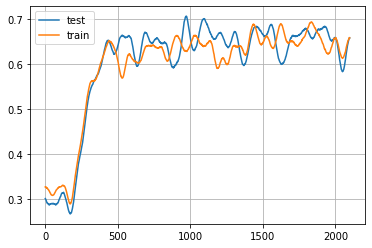

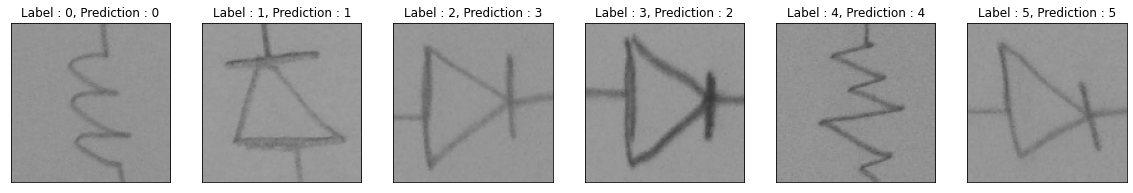

In [101]:
# First, some preprocessing to smooth the training and testing arrays for display.
window_length = 100
train_s = np.r_[
    training[window_length - 1 : 0 : -1], training, training[-1:-window_length:-1]
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# Display the training accuracies.
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(["test", "train"])
plt.grid()

train_set, test_images, test_labels = dataset.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
    with tf.GradientTape() as tape:
        preds = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

_, axarr = plt.subplots(nrows=1, ncols=6, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(6), axarr):
    temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    ax.set_title(
        "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
    )
    ax.imshow(temp_image, cmap="gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()


Found 590 files belonging to 6 classes.


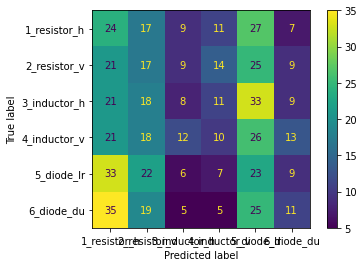

In [136]:
val_ds = keras.utils.image_dataset_from_directory(
    DATA_PATH,
    color_mode='grayscale',
    image_size=(128,128),
)

val_ds = val_ds.map(lambda x,y:( x/255.0, y))

class_names = ['1_resistor_h', '2_resistor_v', '3_inductor_h', '4_inductor_v', '5_diode_lr', '6_diode_du']
labels = np.array([])
for x,y in val_ds:
    labels = np.concatenate([labels, np.array(y)])

test_preds = np.argmax(model.predict(val_ds), axis=-1)

cm = tf.math.confusion_matrix(labels=labels, predictions=test_preds).numpy()
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=class_names)

disp.plot()

In [137]:
image = tf.keras.preprocessing.image.load_img('/content/25.jpeg',
    color_mode = "grayscale",
    target_size=(128,128),
    interpolation='nearest')
input_arr = tf.keras.preprocessing.image.img_to_array(image)/255.0
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)

pred =  np.argmax(model.predict(input_arr), axis=-1)

print(class_names[int(pred)])

4_inductor_v
